# Baseline Evaluation

This notebook evaluates baseline retrieval methods (BM25 and TF-IDF) on TREC-COVID and Climate-Fever datasets.

## How to Run

1. Press "Run All" to execute all cells
2. All required DUMMY files will be created automatically if missing
3. Results will be saved to `output/eval/metric/baseline/`
4. Plots will be saved to `output/eval/plot/baseline/`


In [1]:
# Setup: imports and path configuration
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Notebook is located at runner/eval/baseline.ipynb
project_root = Path.cwd().parents[1]

# Define core configuration
datasets = ["trec_covid", "climate_fever"]
retrieval_methods = ["bm25"]  # baseline retrieval methods we actually support
output_base = project_root / "output"

sys.path.insert(0, str(project_root / 'src'))

from eval import (
    compute_metrics_from_files,
    save_metrics_to_csv,
    load_run_file,
    load_qrels_file,
    compute_per_query_metric,
    compare_runs,
)
from eval.utils import (
    ensure_directory,
    create_summary_table,
)
from notebook.run_api import ensure_baseline_runs

print("Setup complete! Project root:", project_root)


Setup complete! Project root: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms


c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\.venv\Lib\site-packages\beir\datasets\data_loader.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Ensure ingest outputs and baseline runs

Use the programmatic ingest + retrieval API to materialize real artifacts under `output/ingest/{dataset}` and `output/retrieval/baseline/` if they are missing.


In [2]:
# Ensure output directories exist
ensure_directory(output_base / "retrieval" / "baseline")
ensure_directory(output_base / "eval" / "metric" / "baseline")
ensure_directory(output_base / "eval" / "plot")
ensure_directory(output_base / "eval" / "slice")

# Ensure ingest artifacts + baseline runs (BM25) exist
runs = ensure_baseline_runs(datasets=datasets, retrieval_methods=retrieval_methods, top_k=100)
print("Baseline runs ensured:\n", json.dumps(runs, indent=2, default=str))

=== Dataset: trec_covid ===
Loaded ingested dataset 'trec_covid' from C:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\ingest
[trec_covid / bm25] Baseline run already exists at C:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\baseline\bm25_trec_covid.csv

=== Dataset: climate_fever ===
Loaded ingested dataset 'climate_fever' from C:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\ingest
[climate_fever / bm25] Baseline run already exists at C:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\baseline\bm25_climate_fever.csv

Baseline runs ensured:
 {
  "trec_covid": {
    "bm25": "C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-llms\\output\\retrieval\\baseline\\bm25_trec_covid.csv"
  },
  "climate_fever": {
    "bm25": "C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-llms\\output\\retrieva

## Compute Metrics for All 4 Combos

Compute nDCG@10, MAP, Recall@100, MRR for:
- BM25 × TREC-COVID
- BM25 × Climate-Fever  
- TF-IDF × TREC-COVID
- TF-IDF × Climate-Fever


In [5]:
# Compute metrics for all combinations using real ingest outputs
datasets = ["trec_covid", "climate_fever"]
output_base = project_root / "output"
all_metrics = {}

for dataset in datasets:
    qrels_path = output_base / "ingest" / dataset / "qrels.csv"

    for retrieval in retrieval_methods:
        run_path = output_base / "retrieval" / "baseline" / f"{retrieval}_{dataset}.csv"
        metric_path = output_base / "eval" / "metric" / "baseline" / f"{retrieval}_{dataset}.csv"

        # Compute and save metrics
        metrics = compute_metrics_from_files(str(run_path), str(qrels_path), k=10)
        save_metrics_to_csv(
            metrics,
            str(metric_path),
            dataset=dataset,
            method="baseline",
            retrieval=retrieval,
        )

        all_metrics[(dataset, "baseline", retrieval)] = metrics

print("\nMetrics computation complete!")


Metrics computation complete!


## Summary Table


In [6]:
# Create and display summary table
summary_df = create_summary_table(all_metrics)
summary_path = output_base / "eval" / "metric" / "baseline" / "summary.csv"
summary_df.to_csv(summary_path, index=False)

print("Summary Metrics Table:")
print(summary_df.to_string(index=False))
print(f"\nSaved to: {summary_path}")


Summary Metrics Table:
      dataset   method retrieval  ndcg@10      map  recall@100      mrr
   trec_covid baseline      bm25 0.459467 0.462316    0.073530 0.713968
climate_fever baseline      bm25 0.137596 0.163912    0.361846 0.197883

Saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\metric\baseline\summary.csv


## Plot nDCG@10 Comparison


Plot saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\plot\baseline_ndcg_bm25.png


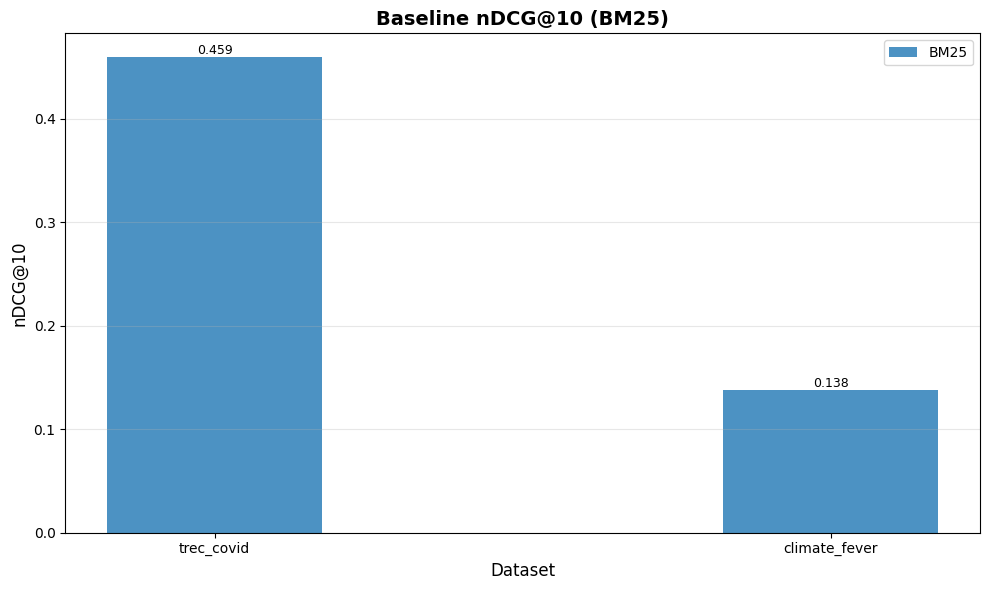

In [7]:
# Plot nDCG@10 comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(datasets))
width = 0.35

bm25_scores = [all_metrics[(d, "baseline", "bm25")]["ndcg@10"] for d in datasets]

bars1 = ax.bar(x, bm25_scores, width, label="BM25", alpha=0.8)

ax.set_xlabel("Dataset", fontsize=12)
ax.set_ylabel("nDCG@10", fontsize=12)
ax.set_title("Baseline nDCG@10 (BM25)", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height,
            f"{height:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()

# Save plot
plot_path = output_base / "eval" / "plot" / "baseline_ndcg_bm25.png"
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"Plot saved to: {plot_path}")
plt.show()


## Robustness Analysis: Compute Query Slices


In [8]:
# Compute query slices for each dataset using ingest outputs (queries + vocab)
from eval.robustness_slices import compute_query_slices, load_vocabulary

for dataset in datasets:
    run_path = output_base / "retrieval" / "baseline" / f"bm25_{dataset}.csv"
    vocab_path = output_base / "ingest" / dataset / "vocab_top50k.txt"
    queries_path = output_base / "ingest" / dataset / "queries.csv"
    slices_path = output_base / "eval" / "slice" / f"{dataset}.csv"

    # Load vocabulary
    vocab = load_vocabulary(str(vocab_path), top_n=50000)

    # Load queries.csv (query_id,text,split)
    queries_df = pd.read_csv(queries_path)
    # Convert query_id to string to match run file format
    queries = {str(row["query_id"]): row["text"] for _, row in queries_df.iterrows()}

    # Compute slices
    slices = compute_query_slices(
        queries,
        str(run_path),
        vocab=vocab,
        output_file=str(slices_path),
    )

    familiar = sum(1 for s in slices.values() if s["label"] == "familiar")
    unfamiliar = len(slices) - familiar

    print(f"{dataset}: {familiar} familiar, {unfamiliar} unfamiliar queries")
    print(f"Slices saved to: {slices_path}")

print("\nRobustness analysis complete!")


trec_covid: 50 familiar, 0 unfamiliar queries
Slices saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\slice\trec_covid.csv
climate_fever: 1534 familiar, 1 unfamiliar queries
Slices saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\slice\climate_fever.csv

Robustness analysis complete!
